<a href="https://colab.research.google.com/github/dhaniyapatta/ecog-joystick/blob/main/linearReg_ecog_joystick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrieval
import os, requests

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Importing packages
!pip install mne --quiet
import mne
import numpy as np
import matplotlib.pyplot as plt
# For elimiating warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import mne.viz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.9 MB/s eta 0:00:00


In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

dat=alldat[0] #data contains data for all 4 subjects


In [ ]:
subjID = 3 #@param {type:"number"}
print("Subjet Chosen:", subjID)
subj = dat[subjID]
subj_name = str('subject '+ str(subjID))

V = subj['V'].astype('float32')
targetX = subj['targetX'].flatten()   # np array 1D
targetY = subj['targetY'].flatten()   # np array 1D
cursorX = subj['cursorX'].flatten()   # np array 1D
cursorY = subj['cursorY'].flatten()   # np array 1D
locs    = subj['locs']                # [[a1 b1 c1] [a2 b2 c2] ... [a60 b60 c60]]
hemisphere = subj['hemisphere']       # list of strings
lobe = subj['lobe']                   # ...
gyrus = subj['gyrus']                 # ...
Brodmann_Area = subj['Brodmann_Area'] # ...


data = V.T
n_channels = V.shape[1]
sampling_freq = 1000  # in Hertz
ch_types = ['ecog']*n_channels
ch_names = ['chan'+str(channel) for channel in list(range(n_channels))]

info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types='ecog', verbose=None)

raw = mne.io.RawArray(data, info)
print(raw.info)

Subjet Chosen: 3
Creating RawArray with float64 data, n_channels=48, n_times=259920
    Range : 0 ... 259919 =      0.000 ...   259.919 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: chan0, chan1, chan2, chan3, chan4, chan5, chan6, chan7, chan8, ...
 chs: 48 ECoG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 48
 projs: []
 sfreq: 1000.0 Hz
>


In [ ]:
subjID = 3 #@param {type:"number"}
print("Subjet Chosen:", subjID)

In [ ]:
# @title Filtering Data
# -----Add filter logic----
def get_filtered_raw(raw):
  raw_filtered = raw.copy().notch_filter(freqs=np.arange(60, 241, 60), picks=['ecog'])
  raw_filtered = raw_filtered.filter(l_freq=0.1, h_freq=30, picks=['ecog'])
  return raw_filtered


In [ ]:
filtered_data=raw_filtered.get_data()
filtered_V=filtered_data.T

In [ ]:
filtered_V.shape

(259920, 48)

In [ ]:
# @title Linear Regression

# @title 5.2. from JC: linear regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter

# set up paramters
def fit_linear(V, targetX, targetY):

  nt, nchan = V.shape

  cx = np.zeros(nchan,)
  cy = np.zeros(nchan,)
  for j in range(nchan):
    cx[j] = np.corrcoef(V[:,j], targetX)[0,1]
    cy[j] = np.corrcoef(V[:,j], targetY)[0,1]

  def rect_data(y):
    z=np.empty_like(y)
    for i in range(np.size(y,1)):
      z[:,i]=(np.abs(y[:,i]))
      return z
  def c_dist(x1,y1,x2,y2):
    d= ((x1-x2) ** 2 + (y1-y2) ** 2 ) ** .5
    return d

  # separating data into train and test
  secval=100000
  v_tr=V[:secval,:]
  x_tr=cursorX[:secval]
  y_tr=cursorY[:secval]

  v_te=V[secval+1:-1,:]
  x_te=cursorX[secval+1:-1]
  y_te=cursorY[secval+1:-1]

  # Creating linear models
  alphav=50
  lm_x=linear_model.LinearRegression()
  lm_y=linear_model.LinearRegression()

  lm_x_r = linear_model.Lasso(alpha=alphav)
  lm_y_r = linear_model.Lasso(alpha=alphav)


  #fitting LMs
  lm_x.fit(v_tr,x_tr)
  lm_y.fit(v_tr,y_tr)

  lm_x_r.fit(v_tr,x_tr)
  lm_y_r.fit(v_tr,y_tr)

  return lm_x, lm_y, lm_x_r, lm_y_r, v_te, x_te, y_te


In [ ]:

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

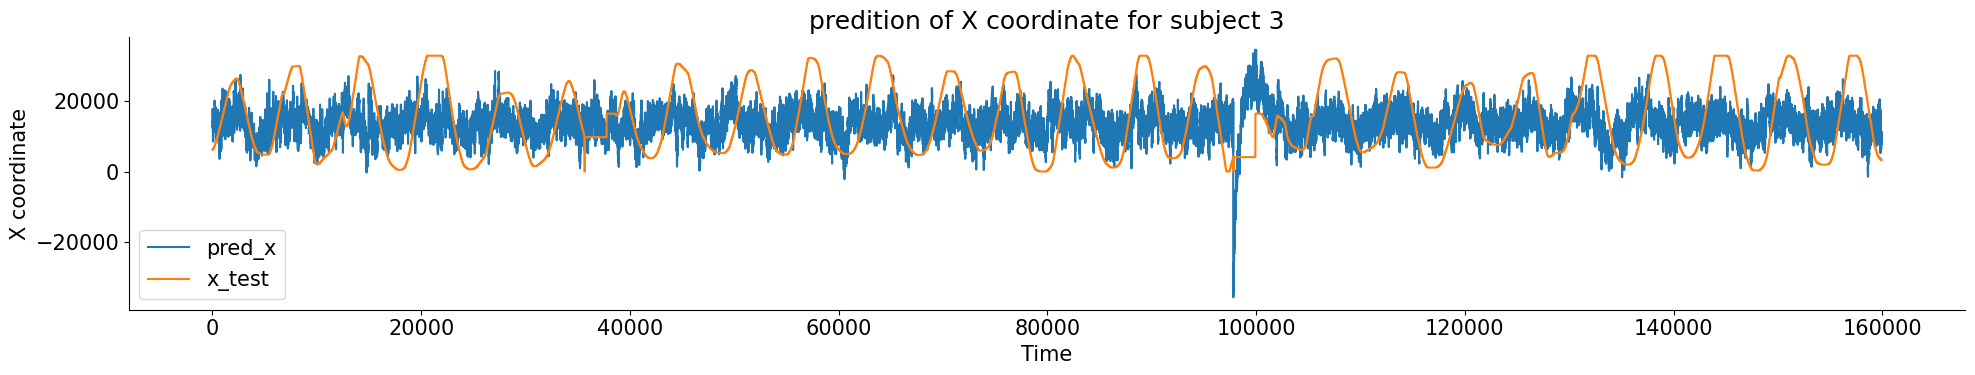

In [ ]:
#X fits_cursor
p_x=lm_x.predict(v_te)
plt.plot(p_x, label='pred_x')
plt.plot(x_te, label='x_test')
plt.title('predition of X coordinate for '+ subj_name)
plt.xlabel('Time')
plt.ylabel('X coordinate')
plt.legend()
plt.show()

In [ ]:
# @title What happens if I filter the XY data too with notch and bandpass

In [ ]:
position_data = np.vstack((cursorX, targetX, cursorY, targetY))
V_data=V.T
extended_data = np.vstack((V_data, position_data))

n_ecog_channels = V.shape[1]

sampling_freq = 1000  # in Hertz
ex_ch_types = ['ecog']*n_ecog_channels + ['misc']*4
ex_ch_names = ['chan'+str(channel) for channel in list(range(n_ecog_channels))]+ ['Xcur']+['Xtar']+ ['Ycur']+ ['Ytar']


ex_info = mne.create_info(ex_ch_names, sfreq=sampling_freq, ch_types=ex_ch_types, verbose=None)
extended_raw = mne.io.RawArray(extended_data, ex_info)

Creating RawArray with float64 data, n_channels=52, n_times=259920
    Range : 0 ... 259919 =      0.000 ...   259.919 secs
Ready.


In [ ]:
extended_filtered_raw=get_filtered_raw(extended_raw)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


In [ ]:
# @title 4.3.0. MNE RAW Object --> np.array


print(extended_filtered_raw[:][0].shape)

extended_raw2nparray = extended_filtered_raw[:][0].T

print(extended_raw2nparray.shape)
filtered_V = extended_raw2nparray[:, :-4]




(52, 259920)
(259920, 52)


In [ ]:
lm_x, lm_y, lm_x_r, lm_y_r, v_te, x_te, y_te=fit_linear(filtered_V, targetX, targetY)

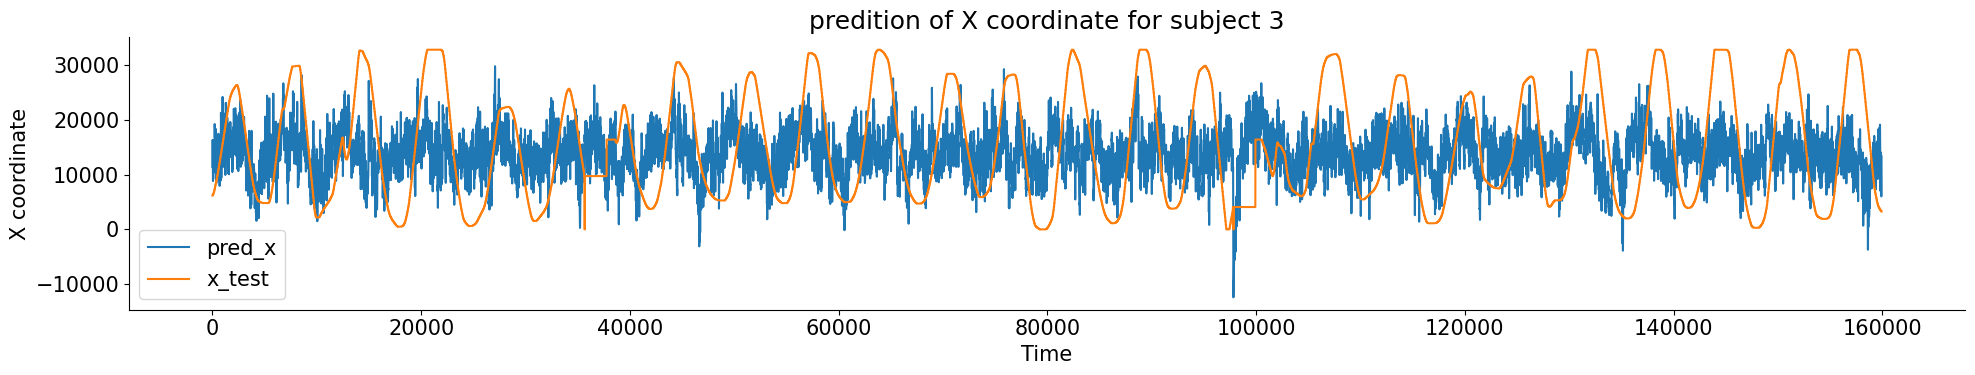

In [ ]:

#X fits_cursor
p_x=lm_x.predict(v_te)
plt.plot(p_x, label='pred_x')
plt.plot(x_te, label='x_test')
plt.title('predition of X coordinate for '+ subj_name)
plt.xlabel('Time')
plt.ylabel('X coordinate')
plt.legend()
plt.show()

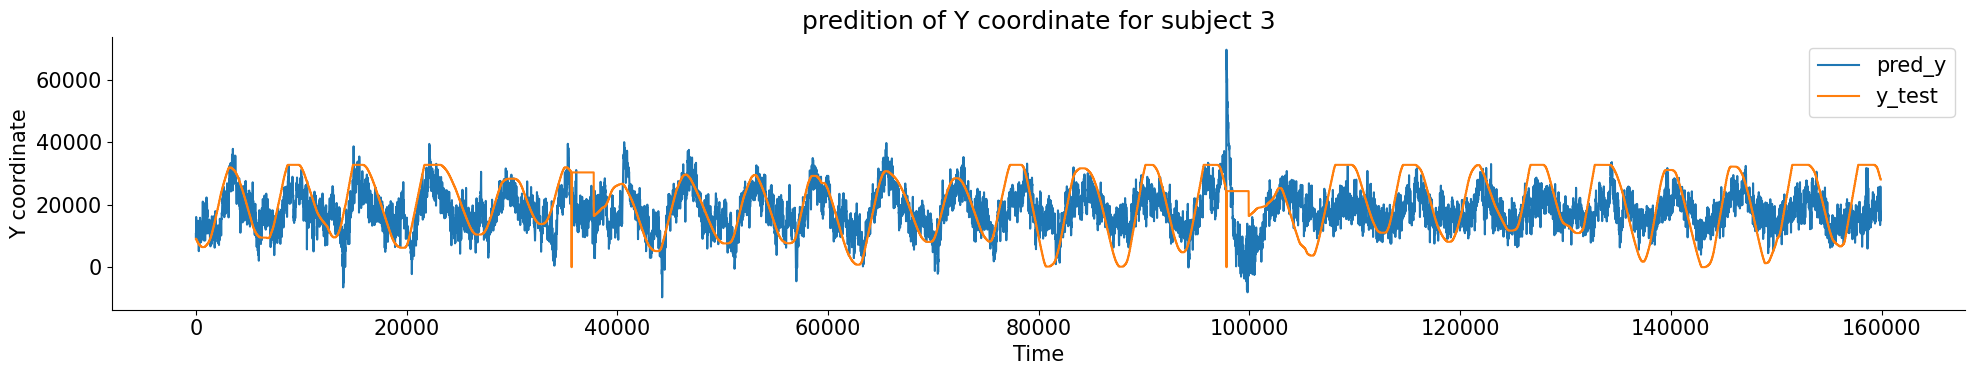

In [ ]:
#Y fits_cursor
p_y=lm_y.predict(v_te)
plt.plot(p_y, label='pred_y')
plt.plot(y_te, label='y_test')
plt.title('predition of Y coordinate for '+ subj_name)
plt.xlabel('Time')
plt.ylabel('Y coordinate')
plt.legend()
plt.show()

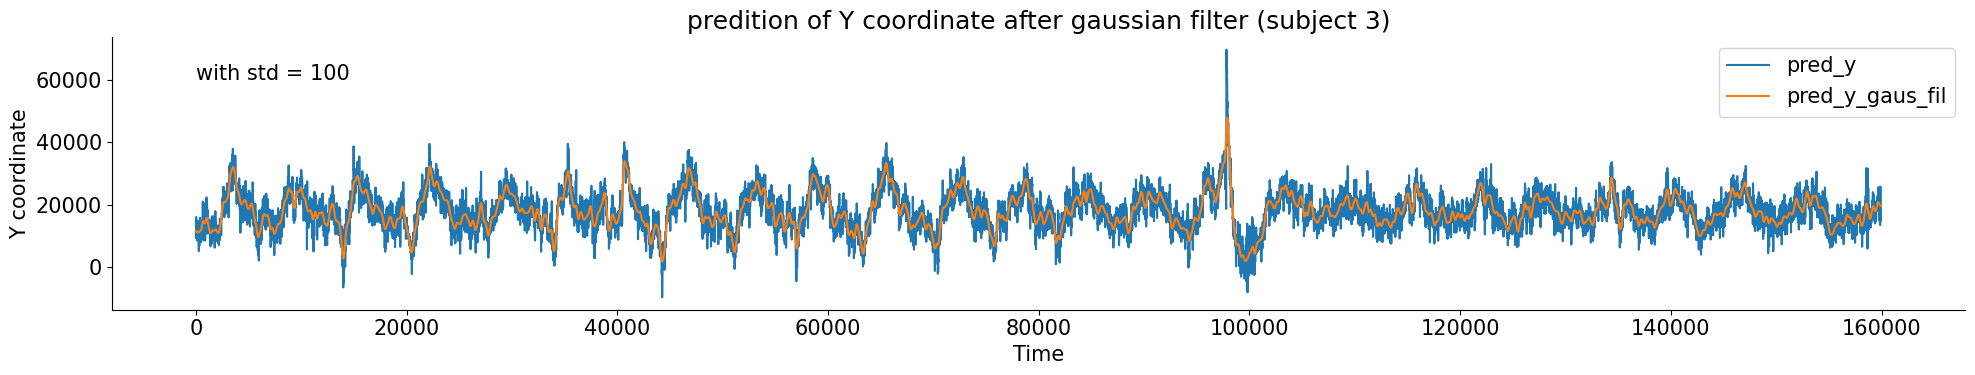

In [ ]:
# @title  Apply gaussian filter on the prediction

from scipy.ndimage import gaussian_filter1d


p_x_gaus_fil = gaussian_filter1d(p_x, 100)
p_y_gaus_fil = gaussian_filter1d(p_y, 100)


plt.plot(p_y, label = 'pred_y')
plt.plot(p_y_gaus_fil, label = 'pred_y_gaus_fil')
plt.title('predition of Y coordinate after gaussian filter ('+ subj_name+ ')')
plt.xlabel('Time')
plt.ylabel('Y coordinate')
plt.text(x=0, y=60000, s='with std = 100')
plt.legend()
plt.show()

In [ ]:
print(x_te.shape)
print(p_x.shape)
print(p_x_gaus_fil.shape)

(159918,)
(159918,)
(159918,)


In [ ]:
def min_max_normalize(arr):
    """
    Normalize a 1D numpy array to the range [0, 1].

    Parameters:
    arr (numpy.ndarray): 1D array to be normalized.

    Returns:
    numpy.ndarray: Normalized 1D array with values between 0 and 1.
    """
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    normalized_arr = (arr - arr_min) / (arr_max - arr_min)
    return normalized_arr

In [ ]:
#calculate accuracy of the LR

import numpy as np
from sklearn.metrics import mean_squared_error

x_te=min_max_normalize(x_te)
y_te=min_max_normalize(y_te)
p_x_gaus_fil=min_max_normalize(p_x_gaus_fil)
p_y_gaus_fil=min_max_normalize(p_y_gaus_fil)

# Calculate Mean Squared Error for X and Y predictions
mse_x = mean_squared_error(x_te, p_x_gaus_fil)
mse_y = mean_squared_error(y_te, p_y_gaus_fil)

print("Mean Squared Error for X prediction:", mse_x)
print("Mean Squared Error for Y prediction:", mse_y)

# You can also calculate Root Mean Squared Error (RMSE) for a more interpretable metric
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)

print("Root Mean Squared Error for X prediction:", rmse_x)
print("Root Mean Squared Error for Y prediction:", rmse_y)


Mean Squared Error for X prediction: 0.1185953817278928
Mean Squared Error for Y prediction: 0.12253729685417579
Root Mean Squared Error for X prediction: 0.3443768019595582
Root Mean Squared Error for Y prediction: 0.3500532771653135


Normalized Array: [0.   0.25 0.5  0.75 1.  ]
